# Convex Optimization

In this notebook, we'll walk through convex optimization problems, how to formulate them, and how to solve them. We start off with 2 prominent cases of convex optimization and afterwards we'll go through the actual methods to find the optimal parameters that solve the problems. The first two sections are more about how to setup the convex optimization problem, while the last section is about how we can find the best parameters to solve the given problem. The formulation and 

### Table of Contents
1. [Least Squares](#ls)
    1. [Linear Least Squares](#lls)
        1. [Ordinary Least Squares](#ols)
        2. [Partial Least Squares](#pls)
        3. [Principal Components Regression](#pcr)
        4. [Weighted Least Squares](#wls)
        5. [Generalized Least Squares](#gls)
        6. [Iteratively reweighted least Squares](#irls)
        7. [Instrumental Variables (IV) Regression](#ivr)
        8. [Total Least Squares](#tls)
    2. [Constrained Linear Least Squares](#clls)
        1. [Equality constrained Least Squares](#ecls)
        2. [Regularized Least Squares](#rls)
        3. [Non-negative Least Squares](#nnls)
        4. [Box-constrained least Squares](#bcls)
        5. [Integer-constrained Least Squares](#icls)
        6. [Phase-constrained least Squares](#pcls)
    3. [Non-linear Least Squares](#nlls)
2. [Constrained Optimization](#co)
    1. [Duality Theory](#duality)
        1. [The Lagrangian](#lagrangian)
        2. [Meaning of Lagrange Multipliers $\lambda$](#lagrangianmeaning)
        3. [Constraint Qualifications](#constraintqualifications)
    2. [Linear Constraints](#lconstraints)
        1. [Linear Programming / Optimization](#lp)
        2. [Quadratic Programming / Optimization](#qp)
    3. [Non-linear Constraints](#nlconstraints)
        1. [Non-linear Programming / Optimization](#nlp)
3. [Solution Strategies](#solnstrat)
    1. Medium-scale Solver
        1. Conjugate Gradient
        2. Interior Point Methods
        3. Active Set Methods
        4. Trust Region Methods
    2. Large Scale Solver
        1. Limiting Memory BFGS
        2. Stochastic Subgradient
        3. Block Coordinate Descent
        4. Operator Splitting Methods

In [2]:
# Scipy's Optimization library for constrained optimization
import scipy.optimize as opt

# Convex Optimization library
import cvxpy as cp

# Machine Learning Utilities
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns
from scipy.stats import norm, f
from sklearn.datasets import make_regression

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

In [3]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

## Preliminaries

### Affine Set
- Contains the line through any two distinct points in the set
    - E.g. Solution set of linear equations ${ \{x\vert Ax = b\} }$
    - Conversely, every affine set can be expressed as solution set of system of linear equations
        - $${ \begin{aligned} Ax_1 &= b \\ Ax_2 &= b \\ Ax &= A(\theta x_1 + (1-\theta)x_2) \\ &= \theta Ax_1 + (1-\theta)Ax_2 \\ &= \theta b + (1-\theta) b \\ &= b\end{aligned} }$$

### Convex Set
- Contains the **line segment** between $x_1$ and $x_2$: all points $x = \theta x_1 + (1-\theta)x_2$ with $0 \leq \theta \leq 1$ 

### Convex Combination
- Generalization of the convex set so that we include all combinations of points ${x_1, \ldots, x_k}$ such that $x = \theta_1x_1 + \ldots + \theta_kx_k$ with $\theta_1 + \ldots + \theta_k = 1\,,\theta_i \geq 0$

### Convex Hull
- The smallest set of all convex combinations of the points in our space (the smallest shaded region of the shape so that any two points in the shaded regoion can see each other)

### Convex Cone
- Set that contains all **non-negative Conic combination** of $x_1$ and $x_2$: any point of the form $x = \theta_1x_1 + \theta_2x_2$ with $\theta_1 \geq 0, \theta_2 \geq 0$ (Looks like a pie slice (plane) - any point on the line from origin to $x_i$ and beyond are multiples of $x_i$ and all points in the shaded region are the non-negative linear combinations of multiples of $x_i$ and $x_j$)

### Convex Function
- A function is [convex when Hessian is PSD](https://www.quora.com/Why-is-a-function-convex-when-its-Hessian-positive-semidefinite)

### Hyperplanes
- Solution set to a single linear **equality** constraint / equation: ${ \{x\vert a^\top x = b\} (a \neq 0) }$
    - $a$ is the normal to that hyperplane
    - Varying $b$ moves the hyperplane perpendicular to $a$ and parallel to the hyperplane

### Halfspace
- Solution set to a single linear **inequality** constraint / equation: ${ \{x\vert a^\top x \leq b\} (a \neq 0) }$
    - The shaded region below the hyperplane for $\leq$ sign
    - $a$ is an **outward** normal vector
    - Hyperplanes are affine and convex, halfspaces are convex
    - Simple Halfspace Proof of Convexity: $$\begin{aligned} a^\top x_1 &\leq b \\ a^\top x_2 &\leq b \\ x &= \theta x_1 + (1-\theta)x_2 , \theta \in [0, 1] \\ a^\top x &= a^\top (\theta x_1 + (1- \theta)x_2) \\ &= \theta a^\top x_1 + (1-\theta) a^\top x_2 \\ &\leq \theta b + (1-\theta)b \end{aligned}$$

---
# 1. Least Squares<a id='ls'></a>

## 1. Linear Least Squares<a id='lls'></a>

Normal Equations:
$$
\hat{\beta} = {(X^\top X)}^{-1}X^\top\mathbf{y}
$$

In [48]:
# Make a random regression dataset
X, y = make_regression(
    n_samples=10000, 
    n_features=1, 
    noise=10, 
    random_state=0
)

If $X$ is invertible, we can solve it analytically:
- Find ${(X^\top X)}^{-1}$

In [57]:
# Using Numpy's pinv function
B_hat = np.dot(
    np.dot(
        np.linalg.pinv(
            np.dot(X.T, X)
        ),
        X.T
    ), 
    y
)

mse_pinv = round(np.mean((y - np.dot(X, B_hat)) ** 2) ** 0.5, 2)
print('RMSE with Numpy\'s pinv function: {}'.format(mse_pinv))

RMSE with Numpy's pinv function: 10.01


If $X$ is either singular or invertible, we can use QR Decomposition:
- $X = QR$, where $Q$ is an [orthogonal matrix](https://en.wikipedia.org/wiki/Orthogonal_matrix) ($Q^\top Q = QQ^\top = I$) and $R$ is upper triangular

$$
\begin{aligned}
\hat{\beta} &= {(X^\top X)}^{-1}X^\top\mathbf{y} \\
\hat{\beta} &= {((QR)^\top (QR))}^{-1}(QR)^\top\mathbf{y} \\
\hat{\beta} &= {(R^\top Q^\top QR)}^{-1}(QR)^\top\mathbf{y} \\
\hat{\beta} &= {(R^\top R)}^{-1}R^\top Q^\top \mathbf{y} \\
\hat{\beta} &= R^{-1} R^{-\top} R^\top Q^\top \mathbf{y} \\
\hat{\beta} &= R^{-1} Q^\top \mathbf{y} \\
R\hat{\beta} &= Q^\top \mathbf{y} \\
\end{aligned}
$$

- Use Gaussian Elimination and Back-substitution to get $\hat{\beta}$

In [58]:
# Perform QR decomp on X
Q, R = np.linalg.qr(X)

# Use inverse of R and multiply Q^Ty
B_hat = np.dot(
    np.dot(
        np.linalg.inv(R),
        Q.T
    ), 
    y
)

mse_qr = round(np.mean((y - np.dot(X, B_hat)) ** 2) ** 0.5, 2)
print('RMSE with QR Decomp: {}'.format(mse_qr))

RMSE with QR Decomp: 10.01


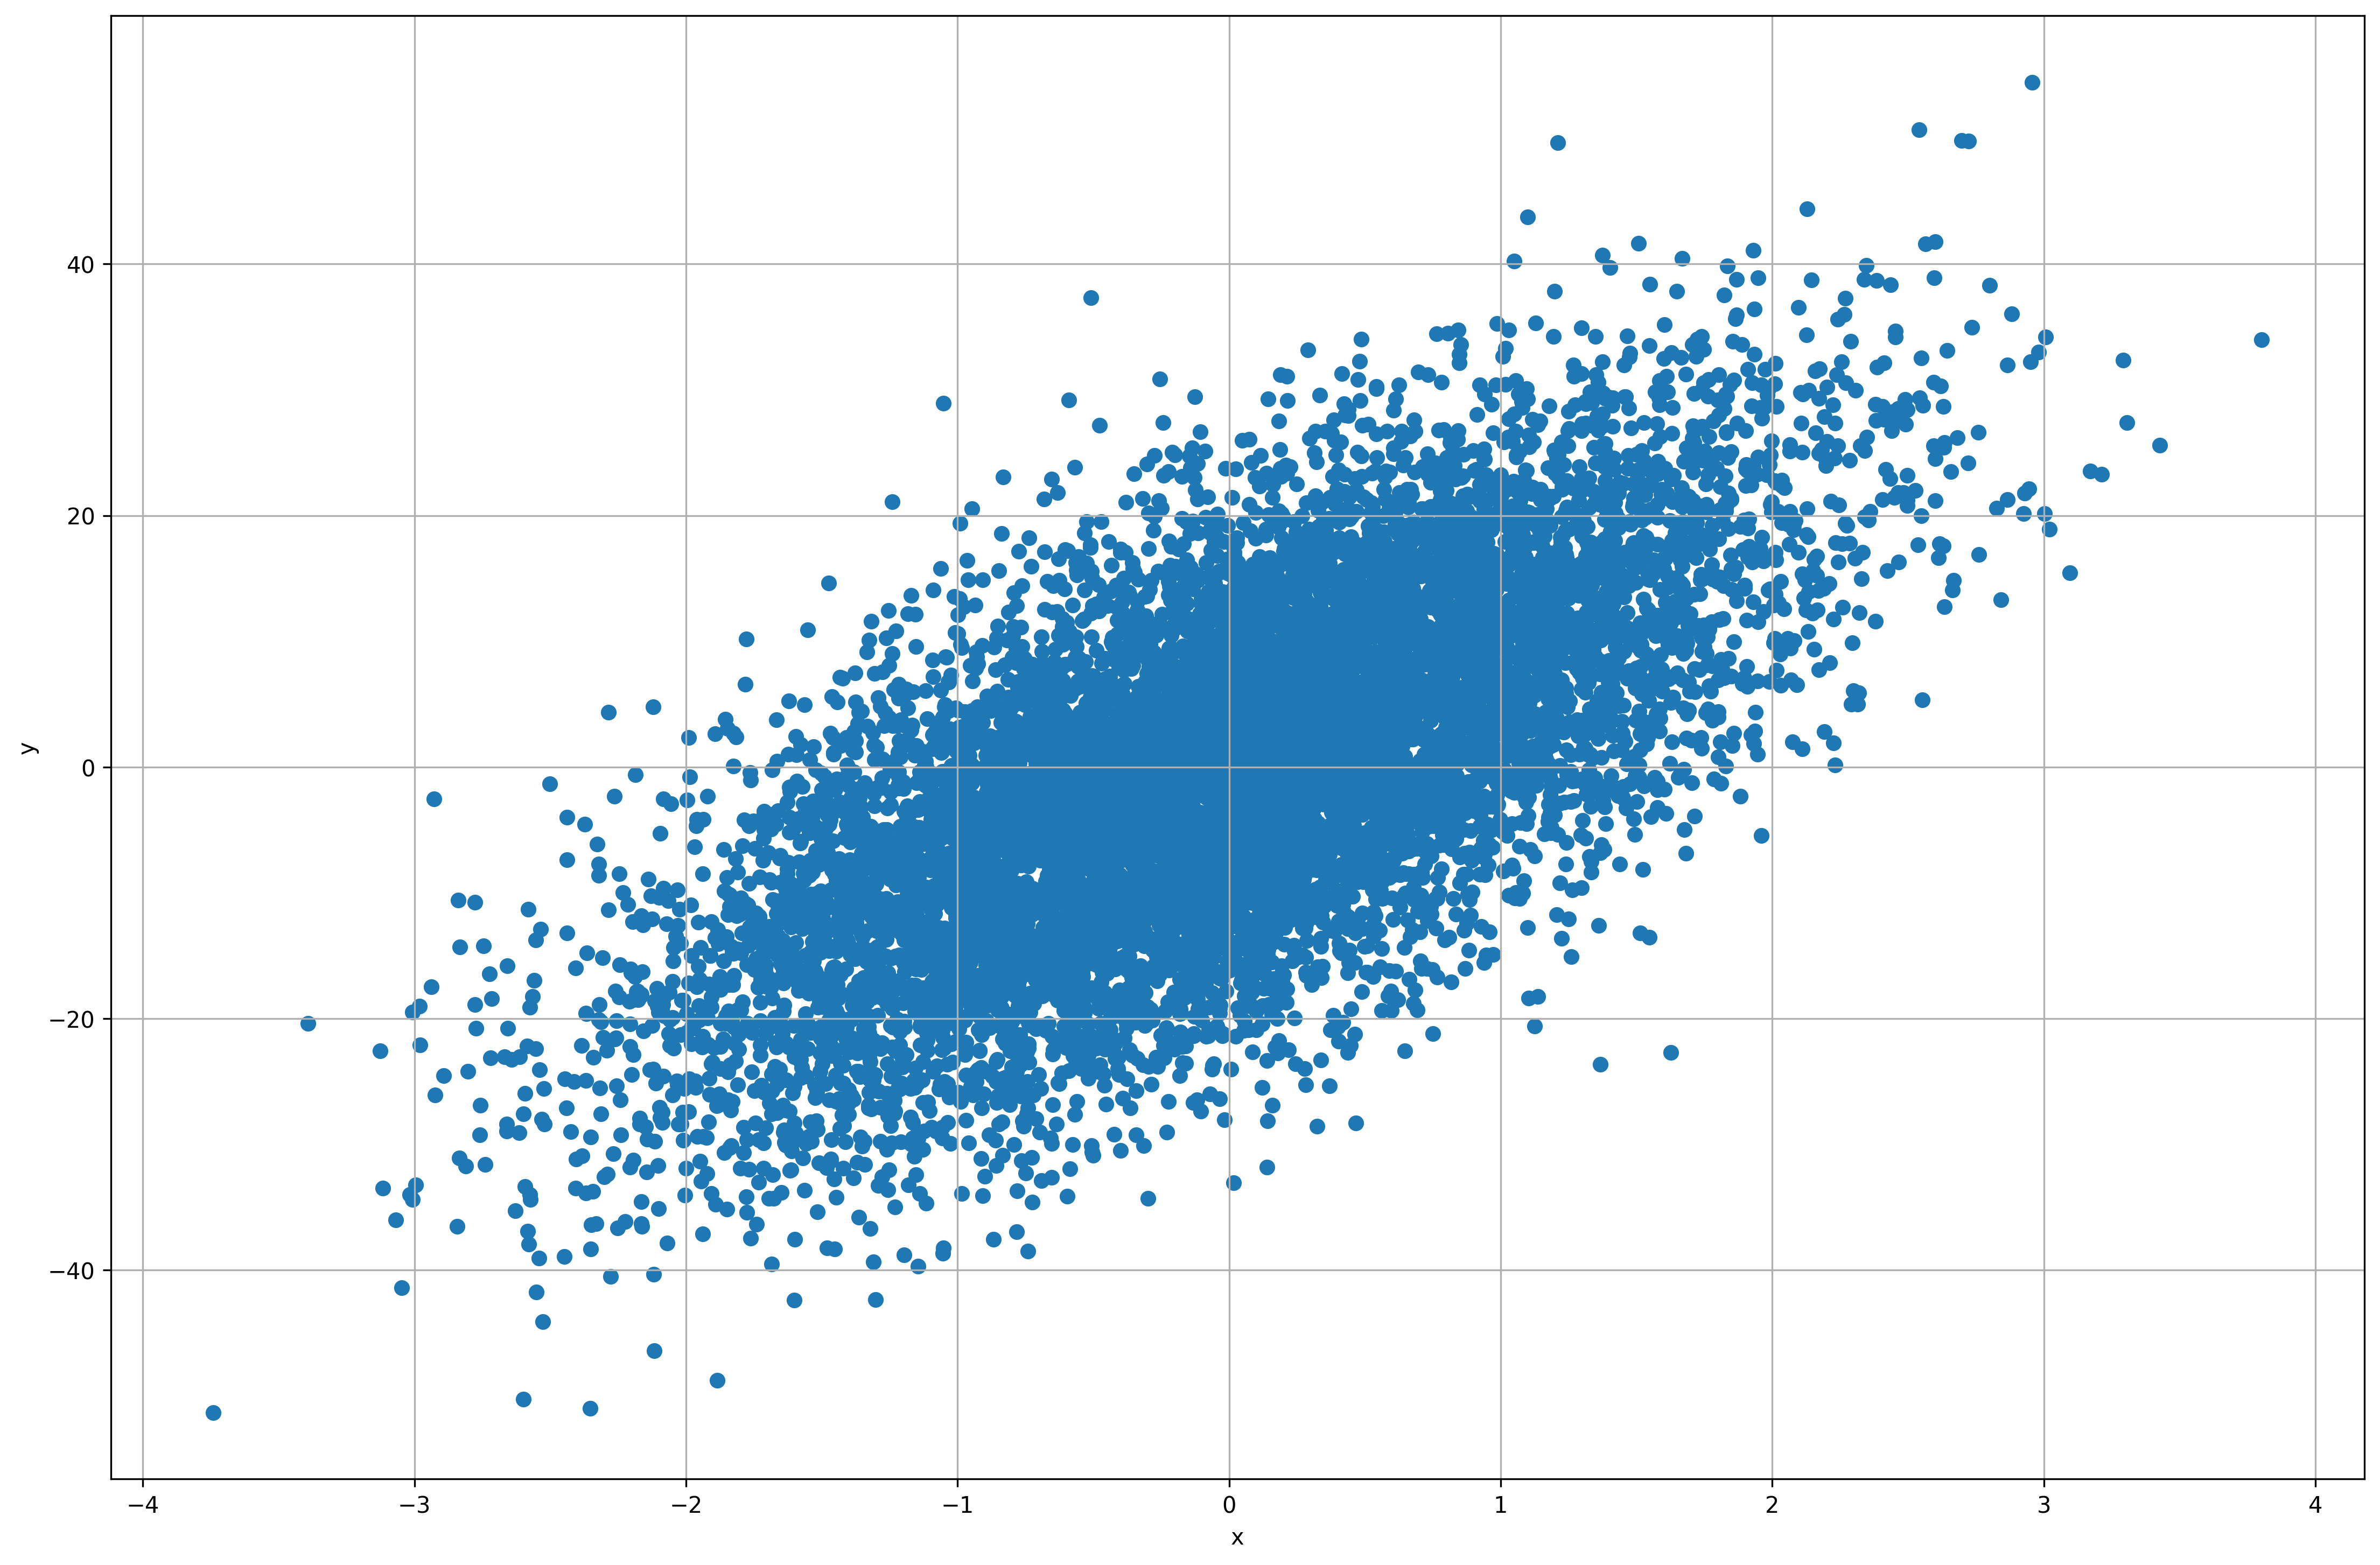

In [59]:
fig, ax = plt.subplots(1, 1)
ax.scatter(X, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid()
plt.show();

### 1. [Ordinary Least Squares](https://en.wikipedia.org/wiki/Ordinary_least_squares)<a id='ols'></a>

In [55]:
opt.least_squares(lambda X, B_hat, y: np.dot(X, B_hat) - y, 0.0)

TypeError: <lambda>() missing 2 required positional arguments: 'B_hat' and 'y'

### 2. Partial Least Squares<a id='pls'></a>

### 3. Principal Components Regression<a id='pcr'></a>

### 4. Weighted Least Squares<a id='wls'></a>

### 5. Generalized Least Squares<a id='gls'></a>


### 6. Iteratively reweighted least Squares<a id='irls'></a>


### 7. Instrumental Variables (IV) Regression<a id='ivr'></a>


### 8. Total Least Squares<a id='tls'></a>



## 2. [Constrained Linear Least Squares](https://en.wikipedia.org/wiki/Constrained_least_squares)<a id='clls'></a>



### 1. Equality constrained Least Squares<a id='ecls'></a>


### 2. Regularized Least Squares<a id='rls'></a>

#### [Tikhonov Regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization)

### 3. Non-negative Least Squares<a id='nnls'></a>


### 4. Box-constrained least Squares<a id='bcls'></a>


### 5. Integer-constrained Least Squares<a id='icls'></a>


### 6. Phase-constrained least Squares<a id='pcls'></a>



## 3. Non-linear Least Squares<a id='nlls'></a>

---
# 2. Constrained Optimization<a id='co'></a>

$$
\begin{aligned}
&\text{Minimize } f_0(x)\\
&\text{subject to } f_i(x) \leq 0, i=1, ..., m \\
\end{aligned}
$$

E.g.

$$
\begin{aligned}
&\text{Maximize } f(x, y) = x^2 y \\
&\text{subject to } x^2 + y^2 = 1 \\
\end{aligned}
\underset{\text{turning equality to inequality}}{\rightarrow}
\begin{aligned}
&\text{Maximize } f(x, y) = x^2 y \\
&\text{subject to } x^2 + y^2 \geq 1 \\
&\text{subject to } x^2 + y^2 \leq 1 \\
\end{aligned}
$$

To solve this, we'll let ${g(x, y) = x^2 + y^2}$, and find $x$ and $y$ such that ${\nabla{f(x, y)} = \lambda\nabla{g(x, y)}}, \lambda , \text{the Lagrange Multiplier} > 0$:

$$
\begin{aligned}
\nabla{f(x, y)} &= \begin{bmatrix} 2xy \\ x^2 \end{bmatrix} \\
\nabla{g(x, y)} &= \begin{bmatrix} 2x \\ 2y \end{bmatrix} \\
&\vdots \\
\begin{bmatrix} 2xy \\ x^2 \end{bmatrix} &= \lambda \begin{bmatrix} 2x \\ 2y \end{bmatrix} \\
&\vdots \\
2xy &= \lambda 2x \\
x^2 &= \lambda 2y \\
x^2 + y^2 &= 1 \\
&\vdots \\
\therefore x &= \frac{+}{-}\sqrt{\frac{2}{3}} \\
y &= \frac{+}{-}\sqrt{\frac{1}{3}} \\
\end{aligned}
$$

However, only the points ${(\sqrt{\frac{2}{3}}, \sqrt{\frac{1}{3}})}$ and ${(-\sqrt{\frac{2}{3}}, \sqrt{\frac{1}{3}})}$ maximize the function to the constraints.

In [16]:
# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Form objective.
obj = cp.Minimize(cp.square(x - y))

# Create the constraints.
constraints = [x + y >= 0]

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 0.0
optimal var 0.0 0.0


### Terminology

Feasible Set: 
- Set of points satisfying the constraints

Feasible Point:
- Point $x$ in the feasible set

Activate Constraint:
- If $f_i(x) = 0$ and $x$ is feasible, then inequality constraint $f_i(x) \leq 0$ is **active** at $x$.

Optimal Value $p^*$:
- $p^* = inf\{f_0(x) \vert x\,\text{satisfies all constraints.}\}$

Optimal Point $x^*$:
- If $x^*$ is feasible and $f(x^*) = p^*$ then $x^*$ is an **optimal point**



## 1. Duality Theory<a id='duality'></a>

### 1. [The Lagrangian](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/lagrange-multipliers-and-constrained-optimization/v/the-lagrangian?modal=1)<a id='lagrangian'></a>

The general form of the Lagrangian is as follows:

$$
\begin{aligned}
&\text{Minimize } f_0(x)\\
&\text{subject to } f_i(x) \leq 0, i=1, ..., m \\
\end{aligned}
$$

By Lagrangian Relaxation of Constraints, we can transform the constrained problem into unconstrained version (Each $x$ is called a *primal variable* and each $\lambda$ is called a *dual variable / lagrange multiplier* and there's one lagrange multiplier / dual variable for each constraint):

$$
\begin{aligned}
\mathcal{L}(x, \lambda) &= f_0(x) + \sum^{m}_{i = 1} \lambda_i f_i (x) \\
\therefore \underset{\lambda \succeq 0}{sup} \mathcal{L}(x, \lambda) &= \underset{\lambda \succeq 0}{sup}\Big{(}f_0(x) + \sum^{m}_{i = 1} \lambda_i f_i (x)\Big{)}\,\,\text{Supremum and Infimum = Max and Min with No Bounds}
\end{aligned}
$$

Taking a look at $\underset{\lambda \succeq 0}{sup}\Big{(}f_0(x) + \sum^{m}_{i = 1} \lambda_i f_i (x)\Big{)}$, we observe that when one of the constraints ${f_i(x)}$ is violated, AKA ${f_i(x) > 0}$, the supremum for the set is $\infty$, and the largest possible supremum would be $f_0(x)$ when $\lambda_i = 0$.

$$
\therefore \underset{\lambda \succeq 0}{sup} \mathcal{L}(x, \lambda) = \Big{\{}\begin{array}{lr} f_0(x)\,\text{when}\,f_i(x) \leq 0\,\forall\,i \\ \infty\,\text{otherwise} \end{array}
$$

#### Lagrangian Primal Problem

Because we want to exclude all the $x$ values that are not in our feasible set and ensure that our constraints hold, we take the infimum of the set of Supremum over Lagrangian:

$$
p^* = \underset{x}{inf}\,\underset{\lambda \succeq 0}{sup} \mathcal{L}(x, \lambda)\,, p^*\text{is also called the Primal Optimal}
$$

However, instead of brute-forcing to search for $p^*$, we can instead find a lower bound for the primal optimal via the **Lagrangian Dual Problem** ...

#### Lagrangian Dual Problem

- The Lagrangian Dual **Problem** is the search for the best lower bound on the solution to the primal problem $p^*$

$$
d^* = \underset{\lambda \succeq 0}{sup}\,\underbrace{\underset{x}{inf} \mathcal{L}(x, \lambda)}_{\text{Lagrange Dual Function}}\,, d^*\text{is also called the Dual Optimal}
$$

- Case 1: $p^* = d^*$
    - We have **strong duality** 

- Case 2: $p^* \geq d^*$
    - We have **weak duality**

- Lagrangian Dual **Function**: $\underset{x}{inf}\,\mathcal{L}(x, \lambda) = \underset{x}{inf}\,\Big{(}f_0(x) + \sum^{m}_{i = 1} \lambda_i f_i (x)\Big{)}$
    - May go to $-\infty$ (e.g. $f_0(x) = x$)?
    - Concave $\because$ Pointwise Infimum of Affine Functions are Concave

#### Proof of Weak Duality (Any type of Optimization Problem)
Theorem: $\forall f: X \times \Lambda \rightarrow \mathbf{R}$:

$$
\begin{aligned}
d^* &\leq p^* \\
\underset{\lambda \in \Lambda}{sup}\,\underset{x \in X}{inf}\,f(x, \lambda) &\leq \underset{x \in X}{inf}\,\underset{\lambda \in \Lambda}{sup}\,f(x, \lambda)
\end{aligned}
$$

Proof: $\forall x_0 \in X\,\text{and}\,\lambda_0 \in \Lambda$:

$$
\begin{aligned}
\underset{x \in X}{inf}\,f(x, \lambda_0) \leq f(x_0, \lambda_0) \leq \underset{\lambda \in \Lambda}{sup}\,f(x_0, \lambda) \\
\underset{x \in X}{inf}\,f(x, \lambda_0) \leq \underset{\lambda \in \Lambda}{sup}\,f(x_0, \lambda) \\
\underset{\lambda_0 \in \Lambda}{sup}\,\underset{x \in X}{inf}\,f(x, \lambda_0) \leq \underset{x_0 \in X}{inf}\,\underset{\lambda \in \Lambda}{sup}\,f(x_0, \lambda) \\
\end{aligned}
$$

- Duality Gap: ${p^* - d^*}$
- For [*convex*](#convex) problems, we have **strong duality**: $p^* = d^* \iff $ **Constraint Qualifications** are met

#### Conclusion
1. Lagrange Dual Problem is easier to solve (simple constraints)
2. $d^*$ can be used as stopping criterion for primal optimization $\because$ finding $d^*$ is finding the best lower bound for the primal optimization problem
3. Dual can reveal hidden structure in the solution

### 2. [Meaning of the Lagrangian Multipliers $\lambda$](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/interpretation-of-lagrange-multipliers?modal=1)<a id='lagrangianmeaning'></a>

Hence, we can rewrite the optimization problem above as:

$$
\mathcal{L}(x, y, \lambda) = f(x, y) - \lambda(g(x, y) - b)
$$

and finding the min / max values $\underset{\lambda \succeq 0}{sup} \mathcal{L}(x, y, \lambda)$ would be simply setting $\nabla\mathcal{L} = 0$:

$$
\nabla\mathcal{L} =
\begin{bmatrix}
\frac{\partial{\mathcal{L}}}{\partial{x}} \\
\frac{\partial{\mathcal{L}}}{\partial{y}} \\
\frac{\partial{\mathcal{L}}}{\partial{\lambda}}
\end{bmatrix} =
\begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}
$$

and solving the equations gets you ${(x^*, y^*, \lambda^*)}$, which solves our constrained optimization problem. Plugging these values back into the Lagrangian, we get:

$$
\begin{aligned}
\mathcal{L}(x^*, y^*, \lambda^*) &= f(x^*, y^*) - \lambda^*(g(x^*, y^*) - b) \\
&= f(x^*, y^*) + 0 \because \text{Constraint}\,g(x, y) = b\,\text{is satisifed} \\
&= M^* \text{Maximum Value of}\,f\,\text{that fufills constraints} \\
\end{aligned}
$$

Firstly, we can think of $b$, the constraint boundary as a variable instead and let's find the derivative of the Langrangian wrt. $b$:

$$
\begin{aligned}
\mathcal{L}(x, y, \lambda, b) &= f(x, y) - \lambda(g(x, y) - b) \\
\frac{\partial{\mathcal{L}}}{\partial{b}} &= \lambda
\end{aligned}
$$

Secondly,

$$
M^*(b) = \mathcal{L}(x^*(b), y^*(b), \lambda^*(b), b)
$$

If we take the derivative of above wrt. $b$:

$$
\begin{aligned}
\frac{dM^*}{db} &= \frac{d}{db}\mathcal{L}(x^*(b), y^*(b), \lambda^*(b), b) \\
&= \frac{\partial{\mathcal{L}}}{\partial{x}}\frac{dx^*}{db} + \frac{\partial{\mathcal{L}}}{\partial{y}}\frac{dy^*}{db} + \frac{\partial{\mathcal{L}}}{\partial{\lambda}}\frac{d\lambda^*}{db} + \frac{\partial{\mathcal{L}}}{\partial{b}}\frac{db}{db} \because \text{Multivariable Chain Rule} \\
&= \frac{\partial{\mathcal{L}}}{\partial{b}} \because \frac{\partial{\mathcal{L}}}{\partial{x}}, \frac{\partial{\mathcal{L}}}{\partial{y}}, \frac{\partial{\mathcal{L}}}{\partial{\lambda}} = 0\,\text{when evaluated at }\,(x^*, y^*, \lambda^*)\,\text{and}\,\frac{db}{db}=1 \\
&= \lambda \,\text{from the first part}
\end{aligned}
$$

Hence, the lagrange multiplier $\lambda$ is actually the rate of change of the max of $f$ wrt. the constraint boundary.

#### Back to Convex Optimization

Recall the standard form of the Convex optimization problem is as follows:

$$
\begin{aligned}
&\text{Minimize } f_0(x)\\
&\text{subject to } f_i(x) \leq 0, i=1, ..., m\,\,\text{where }f_0, ..., f_m\,\text{are convex functions} \\
\end{aligned}
$$

Only Convex Optimization problems that fulfill **constraint qualifications** have **strong duality** $p^* = d^*$, so what are **constraint qualifications** anyway?

### 3. Constraint Qualifications<a id='constraintqualifications'></a>

KKT

Slater's

--- Under Construction ---

## 2. Linear Constraints<a id='lconstraints'></a>

### 1. Linear Programming / Optimization<a id='lp'></a>

$$
\begin{aligned}
&\text{Linear Objective Function: } f(x) = \alpha^\top x \\
&\text{Linear Constraints: } g(x) = Bx - c; h(x) = Cx - d
\end{aligned}
$$

### [Simplex Algorithm](https://www.youtube.com/watch?v=gRgsT9BB5-8)

Suppose a company manufactures different electronic components for computers. Component A requires 2 hours of fabrication and 1 hour of assembly; Component B requires 3 hours of fabriacation and 1 hour of assembly

--- Under Construction ---

### 2. Quadratic Programming / Optimization<a id='qp'></a>

$$
\begin{aligned}
&\text{Quadratic Objective Function: } f(x) = \frac{1}{2} x^\top A x + \alpha^\top x \\
&\text{Linear Constraints: } g(x) = Bx - c; h(x) = Cx - d
\end{aligned}
$$

The Dual formulation of the SVM objective is important as it expresses the objective in terms of inner products which we can perform the "Kernel Trick" which generalizes the euclidean similarity given by inner products to other "kernels" (similarity functions).

### Case: Support Vector Machines<a id='qp-svm'></a>



## 3. Non-linear Constraints<a id='nlconstraints'></a>

### 1. Non-linear Programming / Optimization<a id='nlp'></a>

---
## Resources:
- [Lagrange multipliers and constrained optimization by Grant Sanderson on Khan Academy](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/lagrange-multipliers-and-constrained-optimization/v/constrained-optimization-introduction)
- [Interpreting Lagrange multipliers as Rate of Change of max / min value of optimization problem with respect to the constraint](https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/constrained-optimization/a/interpretation-of-lagrange-multipliers?modal=1)
- [Manfred Huber's Notes on Constrained Optimization](http://ranger.uta.edu/~huber/cse4345/Notes/Constrained_Optimization.pdf)
- [Carlos Fernandez-Granda's Notes on Convex Optimization @ NYU](https://cims.nyu.edu/~cfgranda/pages/MTDS_spring19/schedule.html)
- [Optimization Taxonomy](https://neos-guide.org/content/optimization-taxonomy)
- [David S. Rosenberg on Convex Optimization](https://davidrosenberg.github.io/mlcourse/Archive/2017Fall/Lectures/04b.convex-optimization.pdf)
- [Stephen Boyd's CVX101 @ Stanford](https://lagunita.stanford.edu/courses/Engineering/CVX101/Winter2014/course/#i4x://Engineering/CVX101)
- [David S. Rosenberg's Extreme Abridgment of Stephen Boyd and Vandenberghe’s Convex Optimization notes](https://davidrosenberg.github.io/mlcourse/Notes/convex-optimization.pdf)
- [Constrained Least Squares Wiki](https://en.wikipedia.org/wiki/Constrained_least_squares)
- [Least Squares Notes by Stephen Boyd](https://www.maplesoft.com/applications/download.aspx?SF=129826/LL_74\)_Least_Square.pdf)
- [Least Squares Notes from Stanford's EE104](http://ee104.stanford.edu/lectures/regression.pdf)
- [Least Squares Notes from UCLA's ECE113A](http://www.seas.ucla.edu/~vandenbe/133A/lectures/ls.pdf)